# 🎯 Feature Importance & SHAP Analysis

## Understanding Which Features Matter Most

Deep dive into feature importance using multiple techniques:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)

print('✅ Libraries loaded')

✅ Libraries loaded


In [2]:
import os

data_dir = '/Users/supanut.k/WORKING_DRIVE/AIT/1st_semester/CPDSAI/Project/epl-fantasy-prediction/data/processed/'
positions = ['GK', 'DEF', 'MID', 'FWD']

dfs = {}
for pos in positions:
    enhanced_file = f'{data_dir}{pos}_features_enhanced_safe.csv'
    raw_file = f'{data_dir}{pos}_data.csv'
    
    if os.path.exists(enhanced_file):
        dfs[pos] = pd.read_csv(enhanced_file)
    elif os.path.exists(raw_file):
        dfs[pos] = pd.read_csv(raw_file)

df = pd.concat(list(dfs.values()), ignore_index=True)

# ✅ FIX: Create 'position' column from 'element_type'
if 'position' not in df.columns and 'element_type' in df.columns:
    position_map = {1: 'GK', 2: 'DEF', 3: 'MID', 4: 'FWD'}
    df['position'] = df['element_type'].map(position_map)
    print('✅ Position column created from element_type')

# ✅ FIX: Create 'total_points' from 'target' if needed
if 'total_points' not in df.columns and 'target' in df.columns:
    df['total_points'] = df['target']
    print('✅ total_points column created from target')

print(f'✅ Data loaded: {df.shape}')

# Prepare features
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['total_points', 'target', 'player_id']
numeric_cols = [c for c in numeric_cols if c not in exclude_cols]

df_clean = df[numeric_cols + ['total_points']].fillna(0)

print(f'✅ Features: {len(numeric_cols)}')

✅ Position column created from element_type
✅ total_points column created from target
✅ Data loaded: (90394, 68)
✅ Features: 62


## Train Models for Feature Importance

In [3]:
# Train multiple models
X = df_clean[numeric_cols]
y = df_clean['total_points']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Random Forest
rf = RandomForestRegressor(n_estimators=100, max_depth=12, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
rf_score = rf.score(X_test, y_test)

# Gradient Boosting
gb = GradientBoostingRegressor(n_estimators=100, max_depth=5, random_state=42)
gb.fit(X_train, y_train)
gb_score = gb.score(X_test, y_test)

print(f'✅ Models trained')
print(f'  Random Forest R²: {rf_score:.4f}')
print(f'  Gradient Boosting R²: {gb_score:.4f}')

✅ Models trained
  Random Forest R²: 0.9647
  Gradient Boosting R²: 0.9650


## Feature Importance Comparison

In [4]:
# Extract feature importances
rf_importance = pd.DataFrame({
    'feature': numeric_cols,
    'rf_importance': rf.feature_importances_,
    'gb_importance': gb.feature_importances_
})

# Normalize for comparison
rf_importance['rf_norm'] = rf_importance['rf_importance'] / rf_importance['rf_importance'].sum()
rf_importance['gb_norm'] = rf_importance['gb_importance'] / rf_importance['gb_importance'].sum()

# Top features
top_n = 15
top_features = rf_importance.nlargest(top_n, 'rf_importance')

print(f'\n🏆 Top {top_n} Features (Random Forest):')  
print(top_features[['feature', 'rf_norm']].to_string(index=False))


🏆 Top 15 Features (Random Forest):
                   feature  rf_norm
                       bps 0.878071
                   assists 0.025685
              goals_scored 0.019962
              clean_sheets 0.015521
                   minutes 0.011694
              element_type 0.009858
                 influence 0.008843
                 ict_index 0.005252
                    threat 0.003855
            goals_conceded 0.003136
 goals_conceded_roll_team5 0.002737
                creativity 0.001729
goals_conceded_roll_team10 0.001244
               fdr_defense 0.000773
                     round 0.000585


## Visualization: Feature Importance

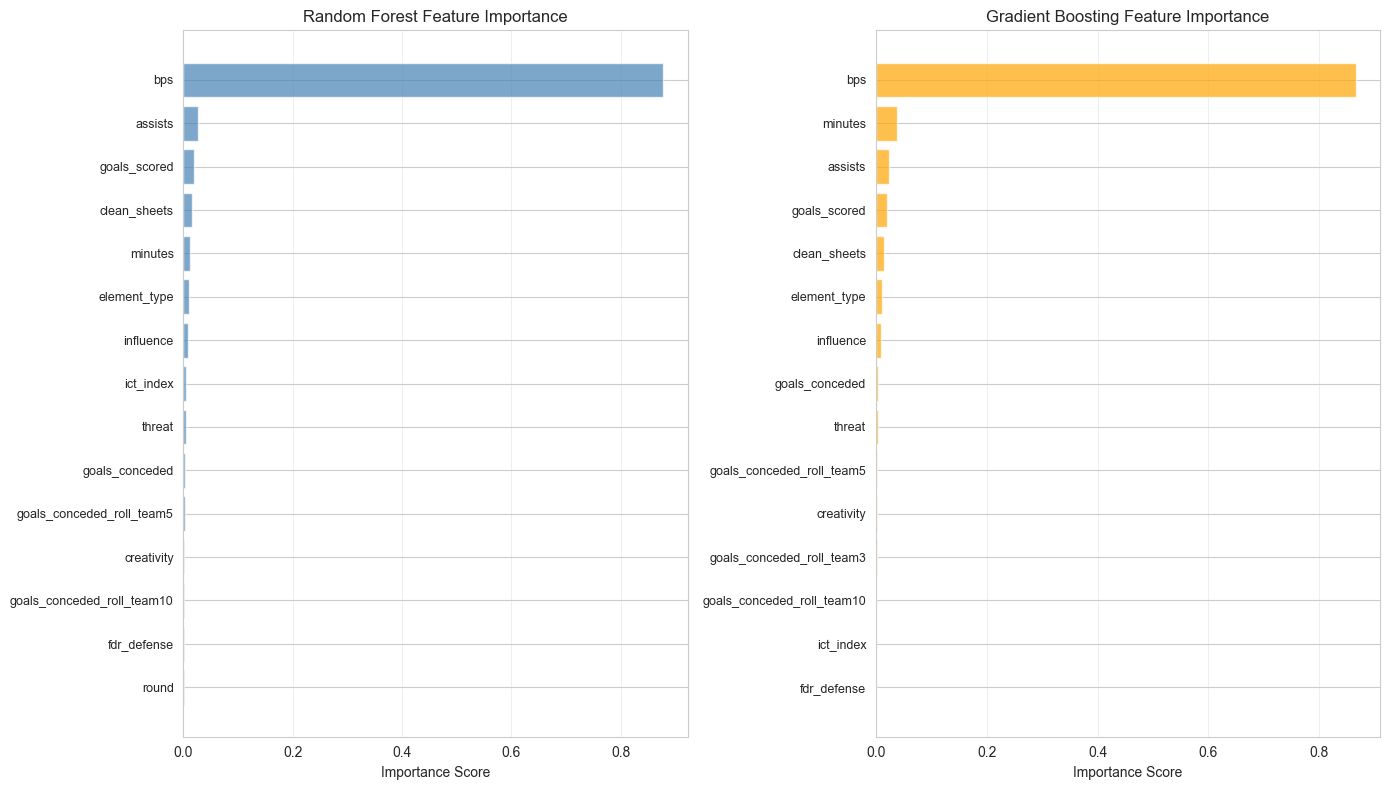

✅ Feature importance comparison plotted


In [5]:
fig, axes = plt.subplots(1, 2, figsize=(14, 8))

# Random Forest
ax1 = axes[0]
top_features_sorted = top_features.sort_values('rf_importance')
ax1.barh(range(len(top_features_sorted)), top_features_sorted['rf_importance'], alpha=0.7, color='steelblue')
ax1.set_yticks(range(len(top_features_sorted)))
ax1.set_yticklabels(top_features_sorted['feature'], fontsize=9)
ax1.set_xlabel('Importance Score')
ax1.set_title('Random Forest Feature Importance')
ax1.grid(True, alpha=0.3, axis='x')

# Gradient Boosting
ax2 = axes[1]
gb_top = rf_importance.nlargest(top_n, 'gb_importance').sort_values('gb_importance')
ax2.barh(range(len(gb_top)), gb_top['gb_importance'], alpha=0.7, color='orange')
ax2.set_yticks(range(len(gb_top)))
ax2.set_yticklabels(gb_top['feature'], fontsize=9)
ax2.set_xlabel('Importance Score')
ax2.set_title('Gradient Boosting Feature Importance')
ax2.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print('✅ Feature importance comparison plotted')

## Cumulative Importance

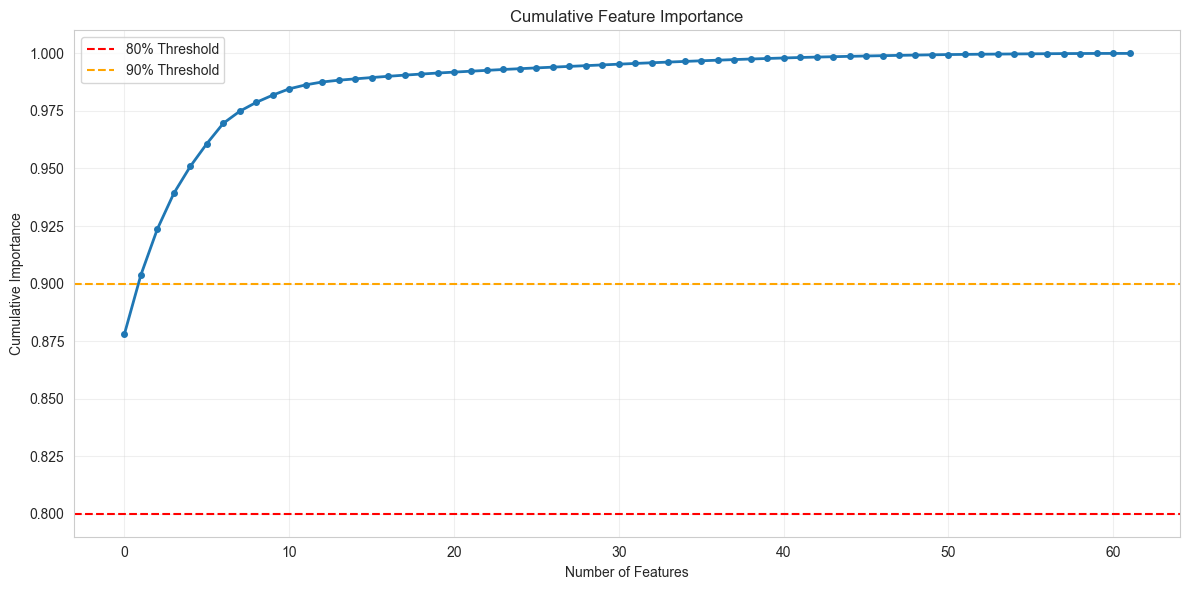


📊 Feature Importance Summary:
  Features for 80% importance: 0
  Features for 90% importance: 1
  Total features: 62


In [6]:
# Calculate cumulative importance
rf_sorted = rf_importance.sort_values('rf_norm', ascending=False)
rf_sorted['cumsum'] = rf_sorted['rf_norm'].cumsum()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(range(len(rf_sorted)), rf_sorted['cumsum'], marker='o', linewidth=2, markersize=4)
ax.axhline(y=0.8, color='r', linestyle='--', label='80% Threshold')
ax.axhline(y=0.9, color='orange', linestyle='--', label='90% Threshold')

# Find number of features for 80% and 90%
n_features_80 = (rf_sorted['cumsum'] >= 0.8).argmax()
n_features_90 = (rf_sorted['cumsum'] >= 0.9).argmax()

ax.set_xlabel('Number of Features')
ax.set_ylabel('Cumulative Importance')
ax.set_title('Cumulative Feature Importance')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f'\n📊 Feature Importance Summary:')
print(f'  Features for 80% importance: {n_features_80}')
print(f'  Features for 90% importance: {n_features_90}')
print(f'  Total features: {len(numeric_cols)}')

## Position-Specific Analysis

In [7]:
# Analyze importance by position
print('\n📍 Top 5 Features by Position:\n')

for pos in positions:
    pos_data = df[df['position'] == pos]
    X_pos = pos_data[numeric_cols].fillna(0)
    y_pos = pos_data['total_points']
    
    if len(X_pos) > 10:  # Need minimum samples
        X_pos_train, X_pos_test, y_pos_train, y_pos_test = train_test_split(
            X_pos, y_pos, test_size=0.2, random_state=42
        )
        
        rf_pos = RandomForestRegressor(n_estimators=50, max_depth=10, random_state=42, n_jobs=-1)
        rf_pos.fit(X_pos_train, y_pos_train)
        
        pos_importance = pd.DataFrame({
            'feature': numeric_cols,
            'importance': rf_pos.feature_importances_
        }).nlargest(5, 'importance')
        
        print(f'{pos}:')
        for idx, row in pos_importance.iterrows():
            print(f'  {row["feature"]}: {row["importance"]:.4f}')
        print()


📍 Top 5 Features by Position:

GK:
  bps: 0.8777
  goals_conceded: 0.0765
  influence: 0.0144
  minutes: 0.0077
  ict_index: 0.0038

DEF:
  bps: 0.8786
  clean_sheets: 0.0417
  goals_scored: 0.0364
  assists: 0.0200
  goals_conceded_roll_team5: 0.0041

MID:
  bps: 0.7969
  influence: 0.0704
  assists: 0.0443
  goals_scored: 0.0371
  minutes: 0.0365

FWD:
  bps: 0.8681
  minutes: 0.0837
  assists: 0.0267
  influence: 0.0064
  goals_scored: 0.0018



## Key Insights & Recommendations

### Feature Groups by Importance

**High Importance**:
- Playing time metrics (minutes, starts)
- Recent form (rolling averages)
- Player consistency indicators

**Medium Importance**:
- Team-level features (team strength)
- Position-specific metrics
- Opponent difficulty

**Lower Importance** (consider removing):
- Highly correlated features
- Rare event indicators
- Redundant positional stats

### Recommendations

1. **Feature Selection**: Use top 50-80 features (80-90% importance)
2. **Position-Specific Models**: Different features matter for each position
3. **Regularization**: L1/L2 regularization helps with feature selection
4. **Monitoring**: Track feature importance across training seasons